Classification using ResNet50 using Image.

Helped from : https://www.kaggle.com/code/baransanatitarrah/resnet50-classifier/notebook#Data-Preprocessing

In [44]:
!pip install opendatasets

In [45]:
dataset_url = "https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset"

import opendatasets as od
od.download(dataset_url)
# "asifhassan2002"

Skipping, found downloaded files in "./breast-ultrasound-images-dataset" (use force=True to force download)


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import sklearn
import cv2
from PIL import Image

In [47]:
SIZE = 224
Base_path = "/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"

In [48]:
%cd /content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT

/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT


# Data Processing

In [49]:
# Function to retrieve image paths and their corresponding labels from a directory
def get_data_and_label(directory):
    dataset = []
    labels = []

    label_dict = {label: index for index, label in enumerate(os.listdir(directory))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)

        for file in os.listdir(label_dir):
            if file and not file.endswith(('mask.png', 'mask_1.png', 'mask_2.png')):
                image_path = os.path.join(label_dir, file)
                image = cv2.imread(image_path)
                image = Image.fromarray(image,'RGB')
                image = image.resize((SIZE, SIZE))
                dataset.append(np.array(image))
                labels.append(index)
    dataset , labels = sklearn.utils.shuffle(dataset, labels)
    return dataset,labels

dataset, label = get_data_and_label(Base_path)

dataset = np.array(dataset)
label = np.array(label)

print(dataset.shape)
print(label.shape)

# Class mapping
class_mapping ={label: index for index, label in enumerate(os.listdir(Base_path))}
inv_class_mapping = {index : label for label, index in class_mapping.items()}
class_names = list(class_mapping.keys())

print(f'\nClass Mapping {class_mapping}')
print(f'\nInverse Class Mapping {inv_class_mapping}')
print(f'\nClass Names {class_names}')

(780, 224, 224, 3)
(780,)

Class Mapping {'benign': 0, 'malignant': 1, 'normal': 2}

Inverse Class Mapping {0: 'benign', 1: 'malignant', 2: 'normal'}

Class Names ['benign', 'malignant', 'normal']


# Viewing Image

In [50]:
def view_img(dataset, label, num_img):
    plt.figure(figsize=(10,10))
    for i in range(num_img*3):
        plt.subplot(num_img,3,i+1)
        random_num = np.random.randint(len(dataset))
        plt.imshow(dataset[random_num])
        plt.title(inv_class_mapping[label[random_num]])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

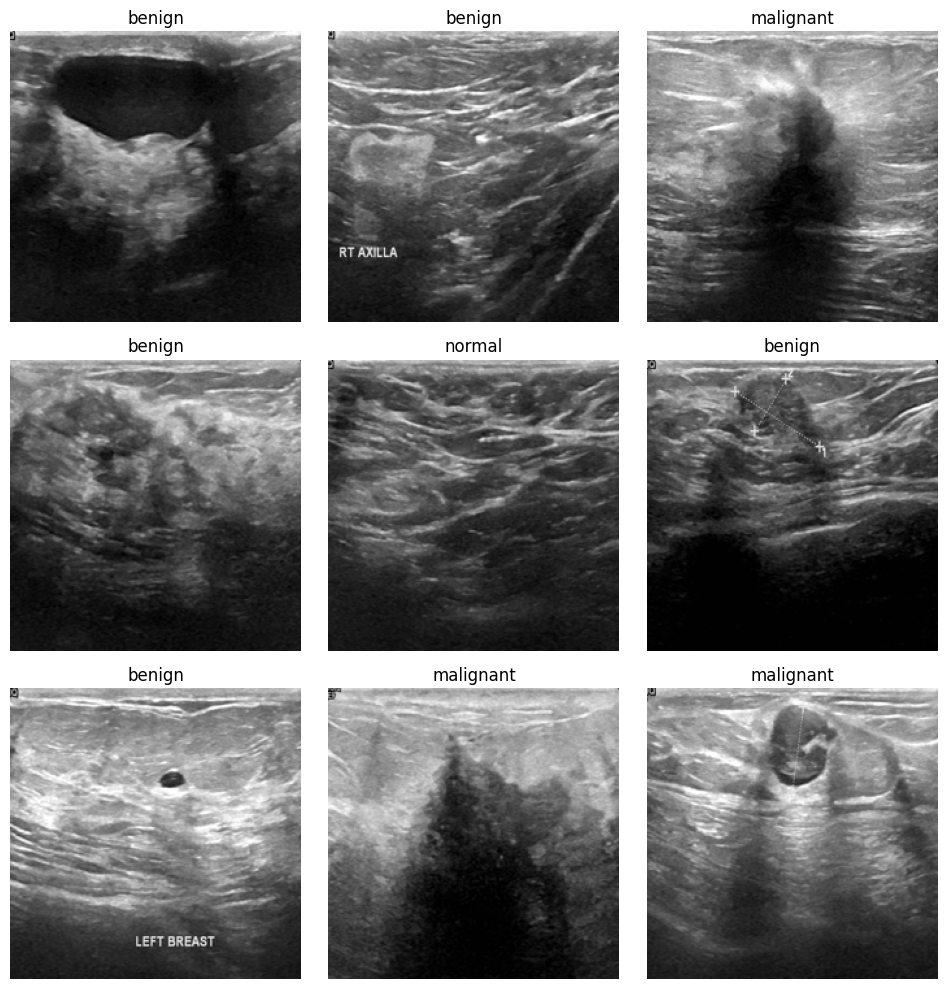

In [51]:
view_img(dataset, label, 3)

# Custom Preprocessing Setting

In [52]:
def custom_preprocessing(image):
    # Apply noise to the image
    noisy_image = add_noise_to_image(image)

    # Apply blur to the image
    blurred_image = apply_blur_to_image(noisy_image)

    # Adjust contrast and brightness
    enhanced_image = adjust_contrast_brightness(blurred_image)

    return enhanced_image

def add_noise_to_image(image):
    # Add noise to the image (customize this function as needed)
    noisy_image = np.clip(image + np.random.normal(loc=0, scale=0.1, size=image.shape), 0, 1)
    return noisy_image

def apply_blur_to_image(image):
    # Apply blur to the image (customize this function as needed)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    return blurred_image

def adjust_contrast_brightness(image):
    # Adjust contrast and brightness (customize as needed)
    img = (image * 255).astype(np.uint8)  # Convert image to uint8 for PIL
    pil_img = Image.fromarray(img)

    enhancer = ImageEnhance.Contrast(pil_img)
    enhanced_img = enhancer.enhance(1.5)  # Increase contrast by a factor of 1.5

    enhancer = ImageEnhance.Brightness(enhanced_img)
    enhanced_img = enhancer.enhance(1.2)  # Increase brightness by a factor of 1.2
    enhanced_img = np.array(enhanced_img) / 255.0

    return enhanced_img

# Splitting the Data to Test and Train and Augmentating the Data

In [53]:
import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [54]:
n_samples,height ,width, n_channel = dataset.shape
x_flat =dataset.reshape(n_samples, -1) # Reshape to (samples, height*width*channels)
x_train , x_test , y_train , y_test = train_test_split(x_flat, label, test_size=0.25, random_state=42)

x_train = x_train.reshape(x_train.shape[0], height, width, n_channel)
x_test = x_test.reshape(x_test.shape[0], height, width, n_channel)

print(x_train.shape)
print(x_test.shape)

(585, 224, 224, 3)
(195, 224, 224, 3)


In [55]:
#Applying different augmentation settings to minority classes:
augmentation_class1 = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=5,  # Rotate images by a maximum of 10 degrees
    width_shift_range=0.1,  # Shift images horizontally by 10% of the width
    height_shift_range=0.1,  # Shift images vertically by 10% of the height
    zoom_range=0.1,  # Zoom images by 10%
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,  # No vertical flipping
    preprocessing_function=custom_preprocessing
)
augmentation_class2 = ImageDataGenerator(
    rotation_range=30,  # Rotate images by a maximum of 10 degrees
    width_shift_range=0.2,  # Shift images horizontally by 10% of the width
    height_shift_range=0.2,  # Shift images vertically by 10% of the height
    zoom_range=0.2,  # Zoom images by 10%
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,
    preprocessing_function=custom_preprocessing

)

#General Augmentation:
datagen = ImageDataGenerator(
    horizontal_flip=True,   # Flip images horizontally
    vertical_flip=True,     # Flip images vertically
    fill_mode='nearest'     # Fill in missing pixels using the nearest available
)

datagen.fit(x_train)
augmented_images = []
augmented_labels = []

# Number of times to augment the data (in this case, we'll double the dataset)
augmentation_factor = 2

for x , y in datagen.flow(x_train, y_train, batch_size = len(x_train), shuffle = False):
    augmented_images.append(x)
    augmented_labels.append(y)

    if len(augmented_images) >= augmentation_factor:
        break

# Concatenate the augmented data batches
x_train = np.concatenate(augmented_images)
y_train = np.concatenate(augmented_labels)

# Verify the shape of augmented data
print("Shape of augmented images:", x_train.shape)
print("Shape of augmented labels:", y_train.shape)

def apply_augmentation(X_train, y_train):
    if y_train == 1:  # Check for class 1
        return augmentation_class1.random_transform(X_train), y_train
    if y_train == 2:
        return augmentation_class2.random_transform(X_train), y_train
    else:
        return X_train, y_train


Shape of augmented images: (1170, 224, 224, 3)
Shape of augmented labels: (1170,)


# Defning and Training the Model


In [56]:
%cd /content

/content


In [57]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint

# Compute class weights
class_labels = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)

# Assign more weight to the second class
class_weights[1] *= 10.0
class_weights[2] *= 10.0
# Create a dictionary of class weights

class_weight = {i: weight for i, weight in enumerate(class_weights)}

print(class_weight)

INPUT_SHAPE = (224, 224, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)

model = Sequential()

pretrained_model= keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='max',classes=3,
                   weights='imagenet')


model.add(pretrained_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())  # Batch Normalization layer
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

#pretrained_model.trainable=False
for layer in pretrained_model.layers:
    layer.trainable = False
# Unfreeze the last few layers for fine-tuning(I achieved much better results adding this step)
for layer in pretrained_model.layers[-12:]:
    layer.trainable = True


optimizer= Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
print(model.summary())


{0: 0.5735294117647058, 1: 13.541666666666668, 2: 19.306930693069305}


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,640,387 (94.00 MB)

 Trainable params: 5,517,315 (21.05 MB)

 Non-trainable params: 19,123,072 (72.95 MB)

None


In [58]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)


checkpoint_path = 'classification_using_img.weights.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max',
                             save_weights_only=True)
#Fit the model
history = model.fit(     x_train,
                         y_train,
                         batch_size = 32,
                         verbose = 1,
                         epochs = 50,
                         #validation_split = 0.1,
                         validation_data=(x_test, y_test),
                         shuffle = True,
                         class_weight=class_weight,
                         callbacks=[checkpoint]
                         #callbacks=[reduce_lr]
                     )

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.4684 - loss: 9.5973
Epoch 1: val_accuracy improved from -inf to 0.63077, saving model to classification_using_img.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 523ms/step - accuracy: 0.4696 - loss: 9.5314 - val_accuracy: 0.6308 - val_loss: 2.6851
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5772 - loss: 4.1823
Epoch 2: val_accuracy improved from 0.63077 to 0.78462, saving model to classification_using_img.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.5769 - loss: 4.1727 - val_accuracy: 0.7846 - val_loss: 1.1835
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6231 - loss: 2.5415
Epoch 3: val_accuracy did not improve from 0.78462
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.6233 - loss: 2.5335 - val_accuracy: 0.6872 - val_loss: 1.2313
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6399 - loss: 1.4142
Epoch 4: val_accuracy did not improve from

In [59]:
model.load_weights(checkpoint_path)

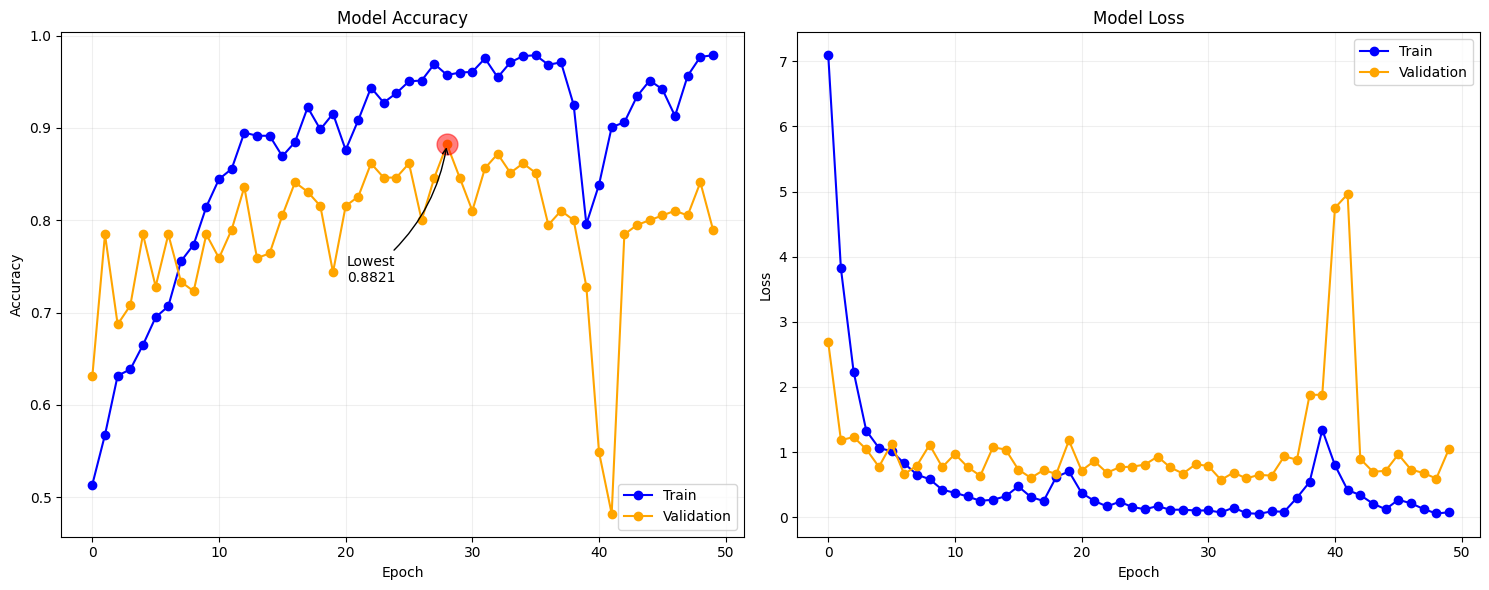

In [64]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
ax[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='lower right')
ax[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
ax[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
ax[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper right')
ax[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
ax[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
ax[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),

xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()


# Evaluation

In [65]:
actual_label =[]
predicted_label = []

for i in range (len(y_test)):
  actual_label.append(np.argmax(y_test[i]))
  # Reshape the input image to a batch of size 1
  pred = model.predict(x_test[i].reshape(1, 224, 224, 3))
  predicted_label.append(np.argmax(pred))

print(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

              precision    recall  f1-score   support

      benign       0.87      0.94      0.90        97
   malignant       0.96      0.74      0.84        66
      normal       0.82      1.00      0.90        32

    accuracy                           0.88       195
   macro avg       0.88      0.89      0.88       195
weighted avg       0.89      0.88      0.88       195



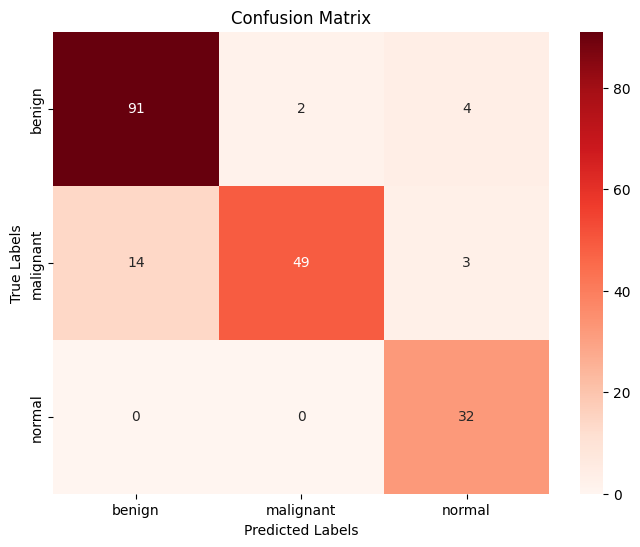

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cm = confusion_matrix(actual_label, predicted_label)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show

print(classification_report(actual_label, predicted_label, target_names=class_names))

In [67]:
# Get some random indices from the test set

def viewing_predicted_img(model,x_test, y_test, num_img):
    plt.figure(figsize=(10,10))
    for i in range(num_img*3):
        plt.subplot(num_img,3,i+1)
        random_num = np.random.randint(len(x_test))
        actual_label = np.argmax(y_test[random_num])
        pred = model.predict(x_test[random_num].reshape(1, 224, 224, 3))
        predicted_label = np.argmax(pred)
        plt.imshow(x_test[random_num])
        plt.title(f"Actual: {inv_class_mapping[actual_label]}\nPredicted: {inv_class_mapping[predicted_label]}")
        plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


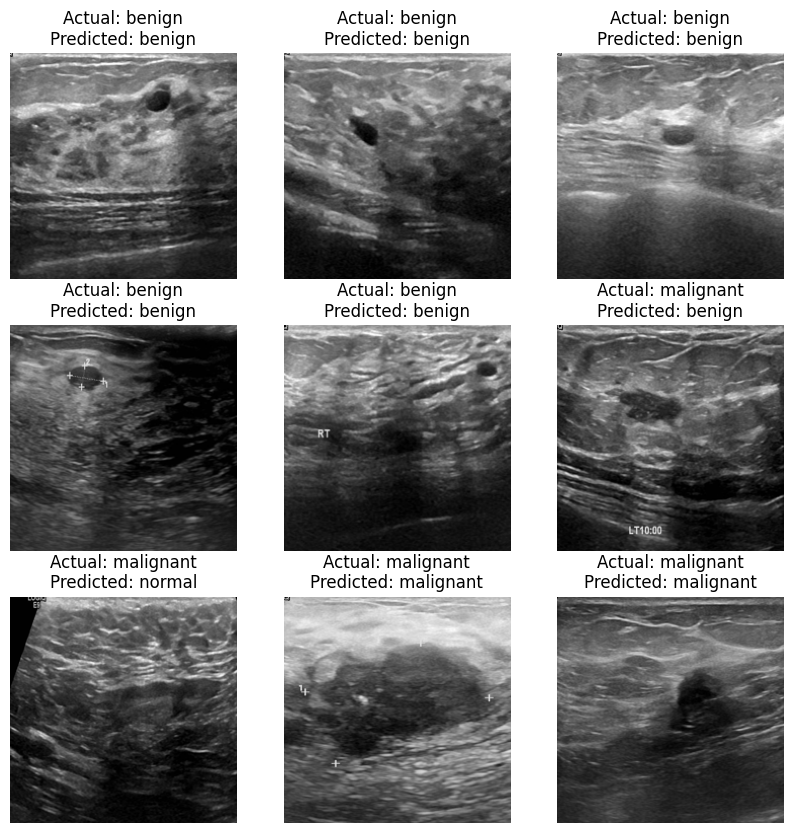

In [68]:
viewing_predicted_img(model, x_test ,y_test,3)